In [98]:
from imports import * 

In [99]:
def compute_delta_fr_slope_pop(neurons,first,second):
    first_epoch = bk.compute.binSpikes(neurons,start = first[0],stop = first[1],nbins = 1)[1][:,0].mean()/(first[1]-first[0])
    second_epoch = bk.compute.binSpikes(neurons,start = second[0],stop = second[1],nbins = 1)[1][:,0].mean()/(second[1]-second[0])

    slope = np.array((second_epoch-first_epoch)/(second[0]-first[1]))
    
    return slope


In [100]:
def main(base_folder,local_path,*args,**kwargs):
    stru = kwargs['stru']
    types = kwargs['types']
    time_from_border = kwargs['time_from_border']
    length_compute_fr = kwargs['length_compute_fr']

    bk.load.current_session_linux(base_folder,local_path)
    states = bk.load.states(True)
    neurons, metadata = bk.load.spikes()
    neurons = neurons[(metadata.Region == stru) & (metadata.Type == types)]
    
    intervals, timing = bk.compute.transition(states,['NREM','REM','NREM'],epsilon = [200,30,200])
    slopes = {}
    slopes['REM'] = []
    for t1,t2 in timing/1_000_000: 
        first = (t1-time_from_border-length_compute_fr),(t1-time_from_border)
        second = (t2+time_from_border),(t2+time_from_border+length_compute_fr)
        slopes['REM'].append(compute_delta_fr_slope_pop(neurons,first,second))
    slopes['REM'] = pd.DataFrame(slopes['REM'],columns=['slopes'])
    slopes['REM']['State'] = 'REM'

    slopes['NREM'] = []
    states['NREM'] = states['NREM'].drop_short_intervals(250, 's').reset_index(drop=True)
    bk.misc.discard_border(states['NREM'],20)
    for s,e in states['NREM'].as_units('s').iloc:
        first = (s,s+length_compute_fr)
        second = (e-length_compute_fr,e)
        slopes['NREM'].append(compute_delta_fr_slope_pop(neurons,first,second))
    slopes['NREM'] = pd.DataFrame(slopes['NREM'],columns=['slopes'])
    slopes['NREM']['State'] = 'NREM'

    slopes = pd.concat(slopes)

    return slopes

100%|██████████| 61/61 [01:22<00:00,  1.36s/it]

['Rat08-20130708', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140620', 'Rat10-20140628', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150323', 'Rat11-20150325', 'Rat11-20150327', 'Rat11-20150328', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 82.7814781665802
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Ra

Text(0.5, 1.0, 'Slopes of FR during NREM or REM sleep')

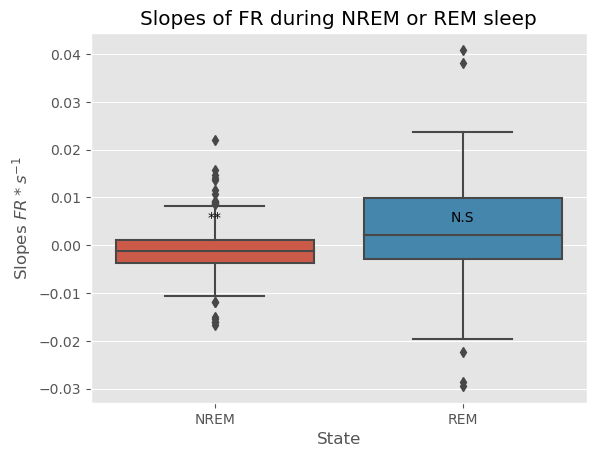

In [101]:
kwargs = {'stru': 'BLA',
          'types': 'Int',
          'time_from_border':20,
          'length_compute_fr':20}

# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
batch,metadata = bk.load.batch(main,**kwargs)

df = pd.concat(batch)

pval = {}
for state in ['NREM','REM']:
    pval[state] = bk.stats.formatting_pvalues(np.array(scipy.stats.ttest_1samp(df['slopes'][df.State == state],0).pvalue))

sns.boxplot(df,y = 'slopes',x = 'State',order = ['NREM','REM'])
for i,state in enumerate(['NREM','REM']):
    plt.text(i,0.005,pval[state],horizontalalignment = 'center')
 
plt.ylabel('Slopes $FR * s^{-1}$')
plt.title('Slopes of FR during NREM or REM sleep')

100%|██████████| 61/61 [01:26<00:00,  1.42s/it]

['Rat08-20130710', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 86.65802836418152
Some session were not processed correctly
['Rat08-20130710', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
26.229508196721312 %


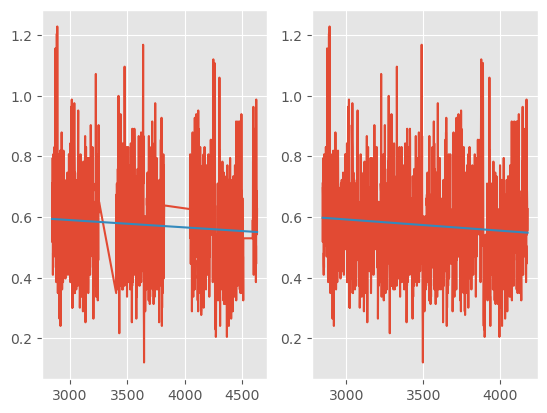

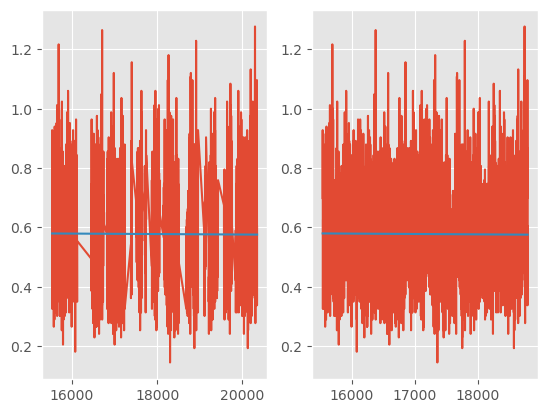

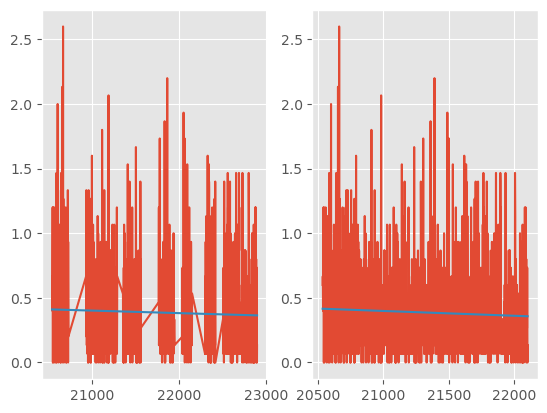

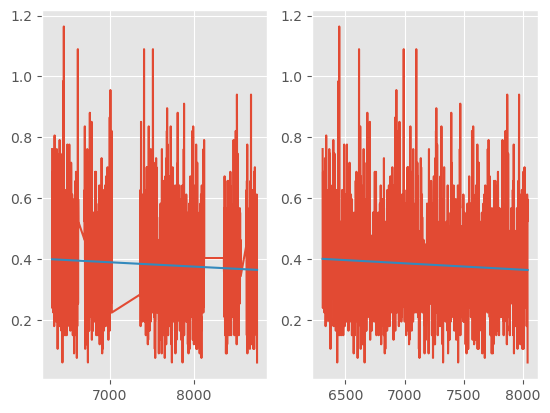

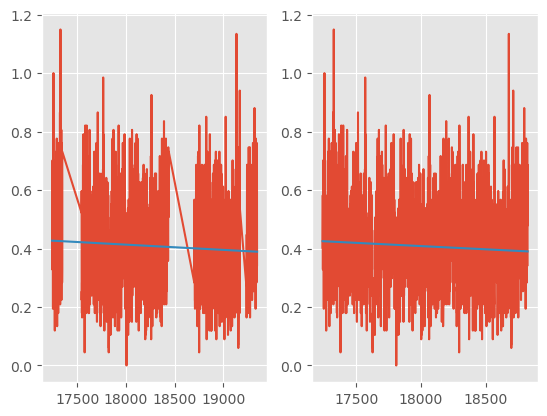

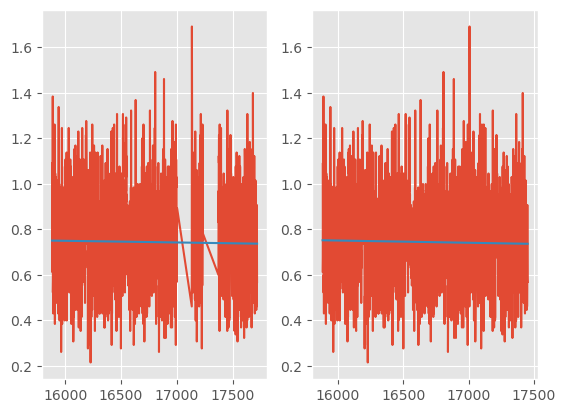

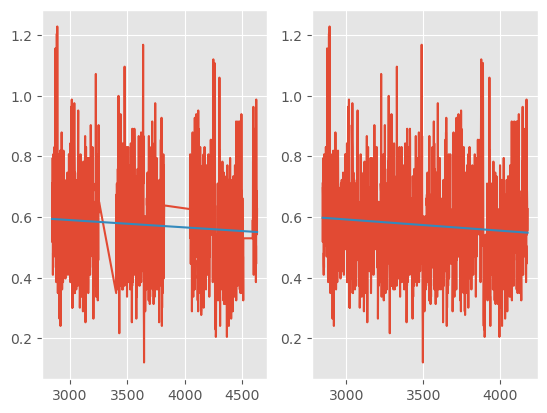

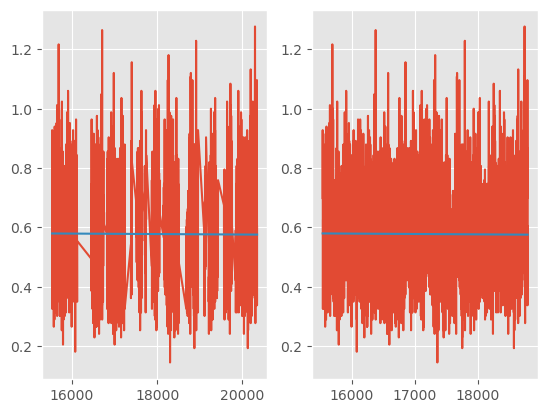

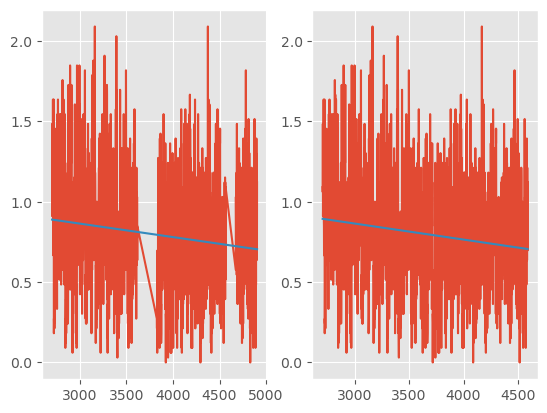

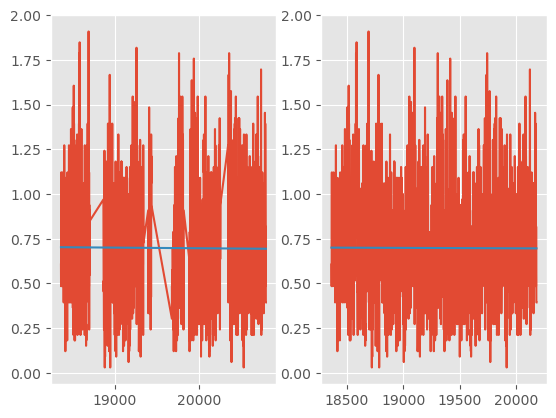

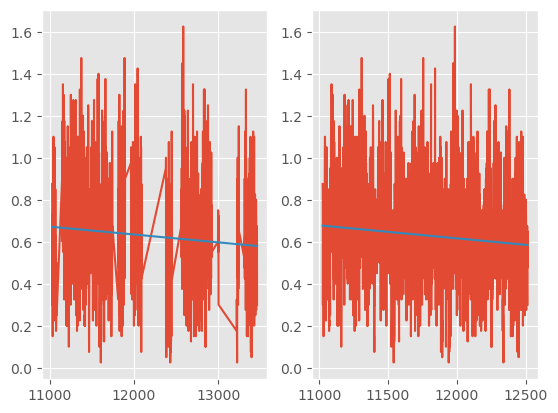

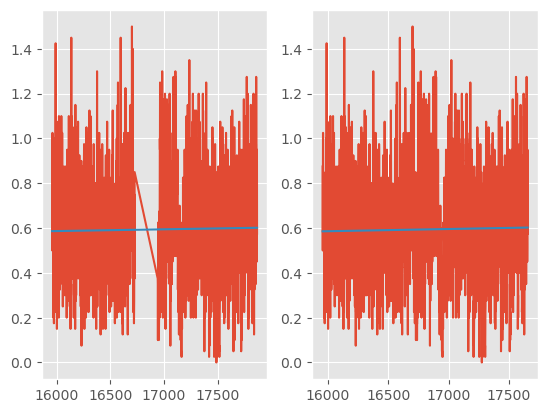

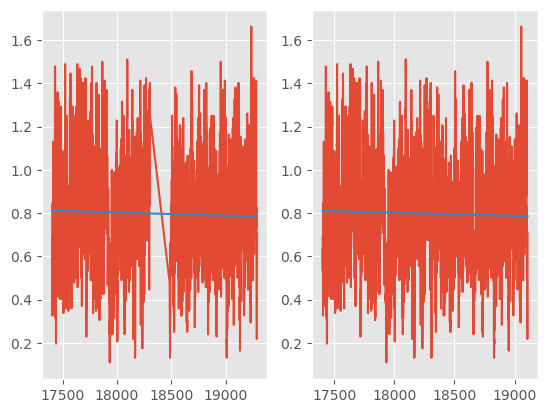

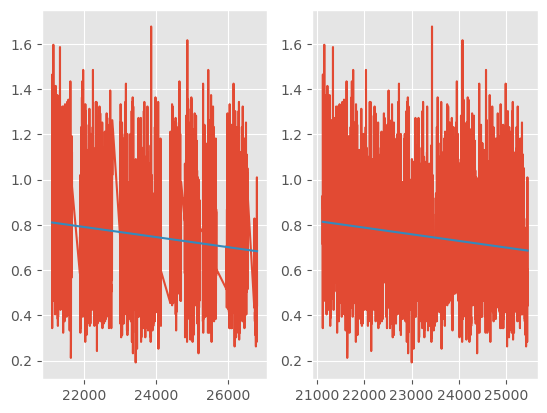

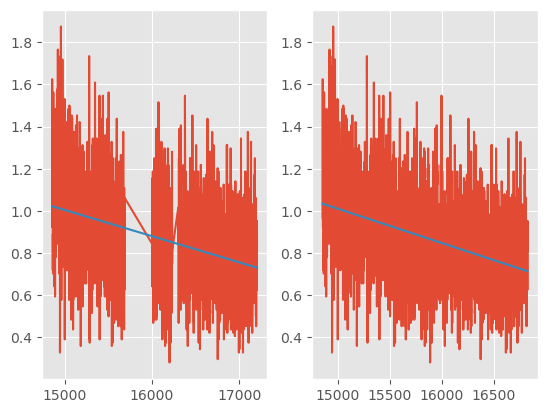

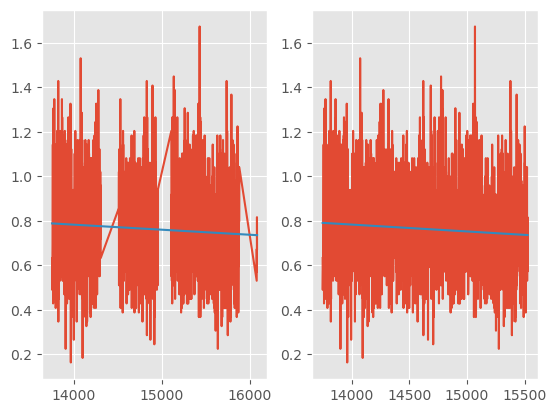

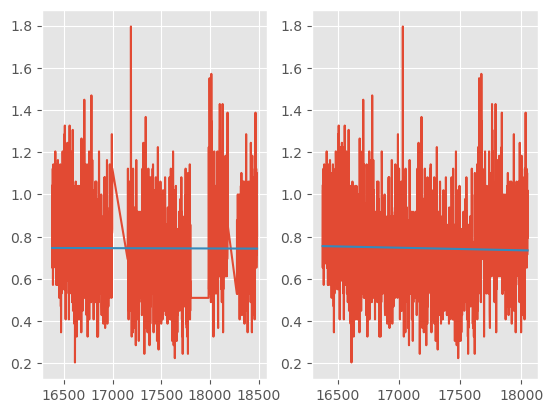

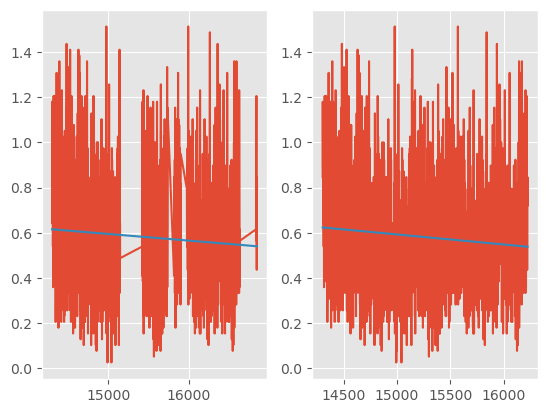

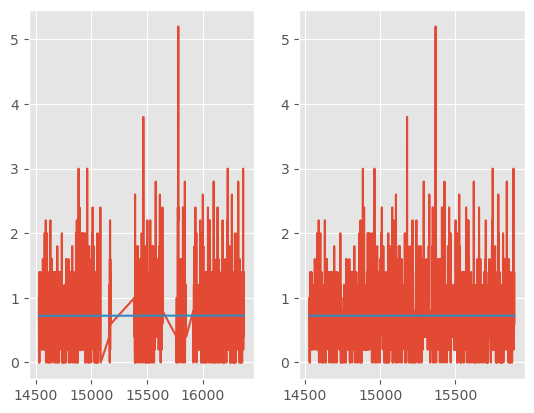

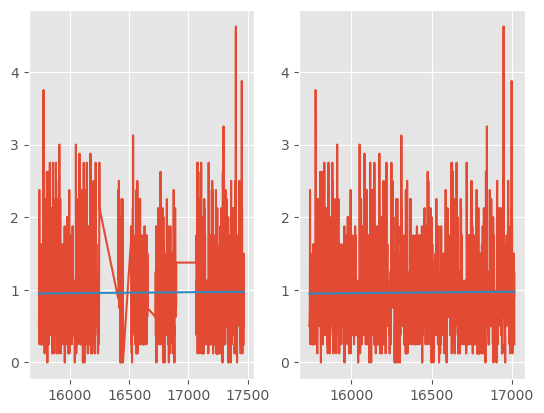

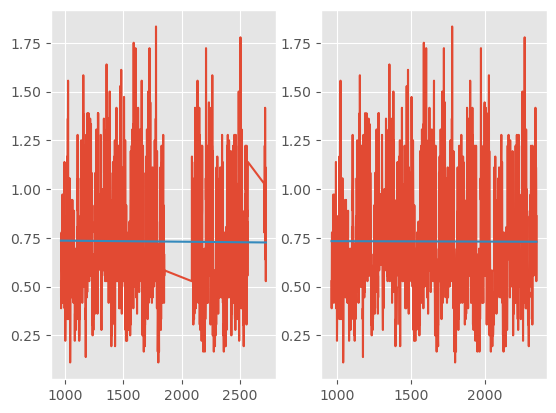

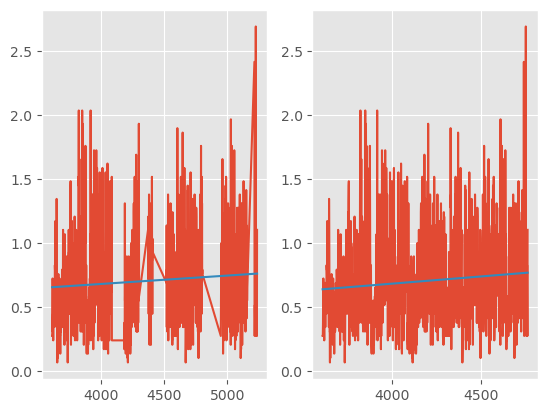

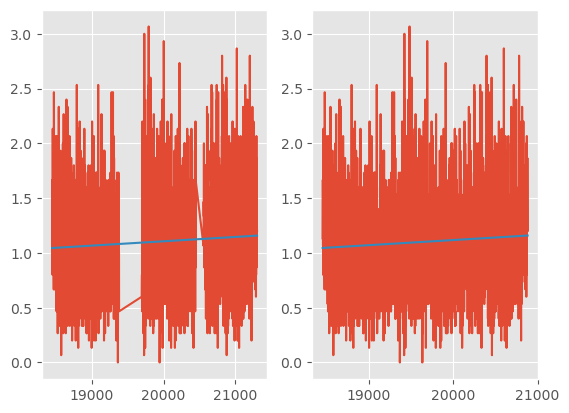

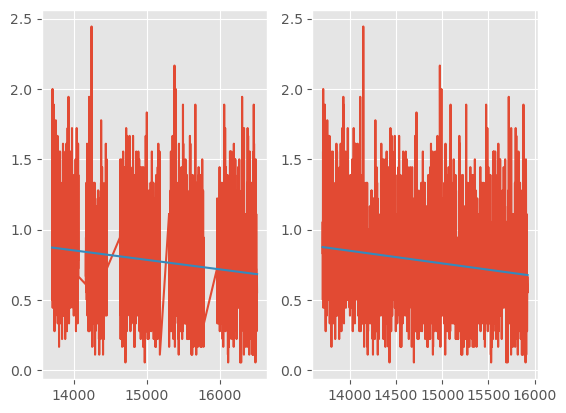

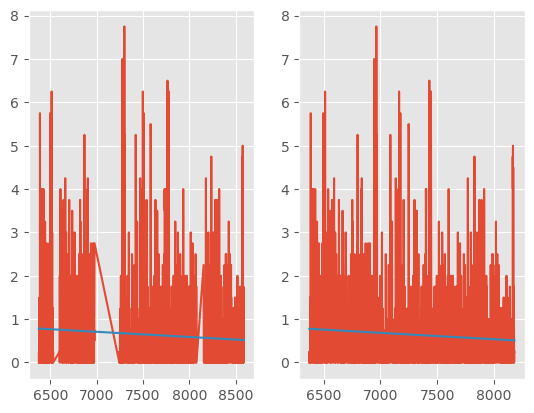

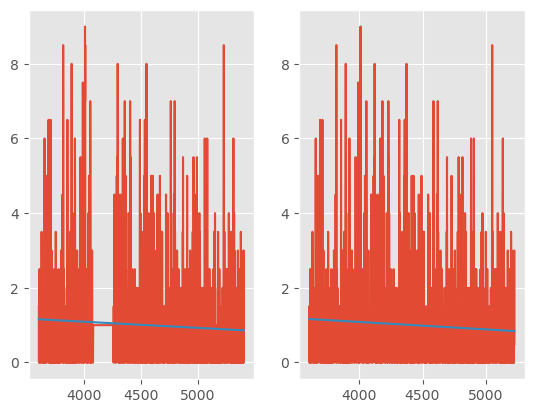

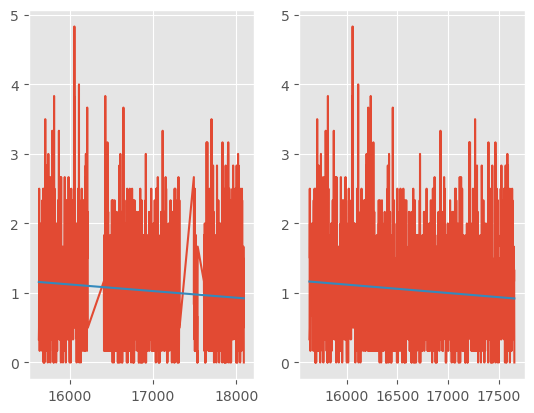

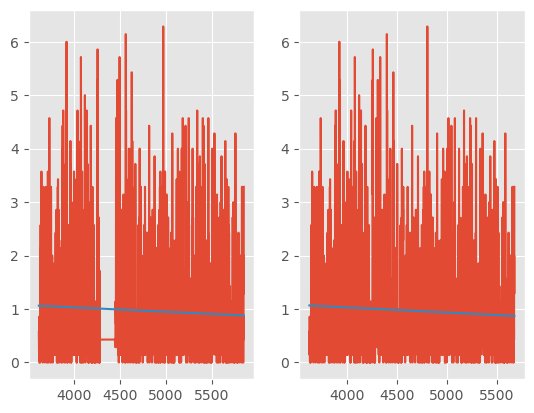

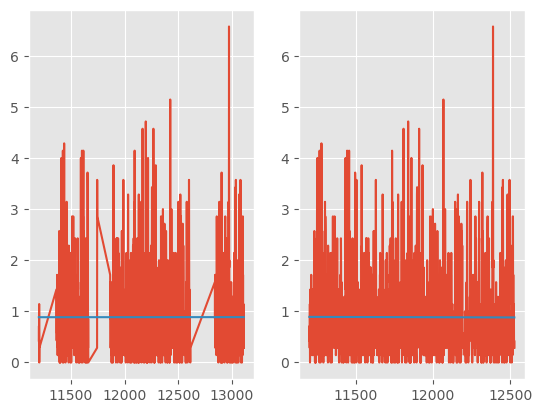

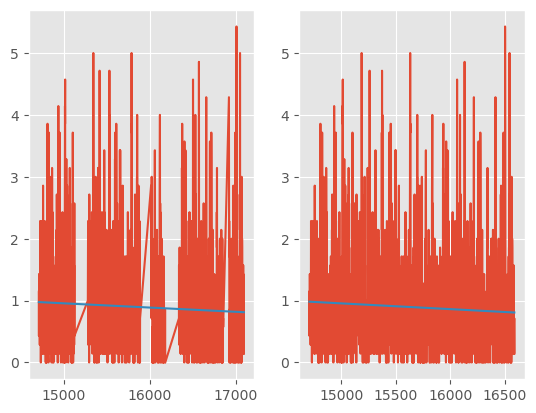

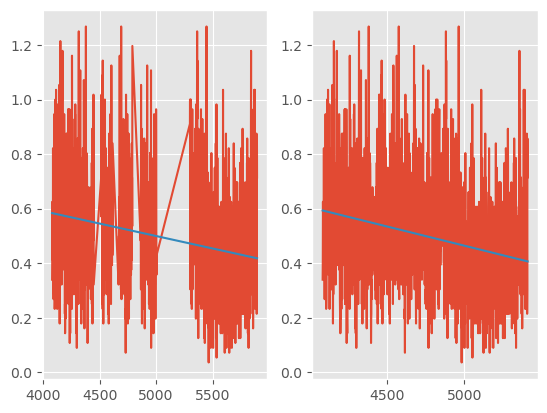

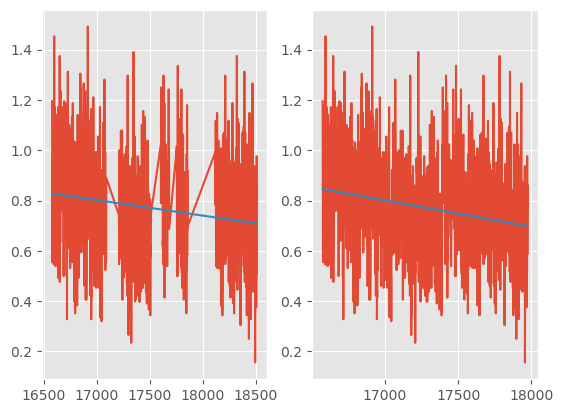

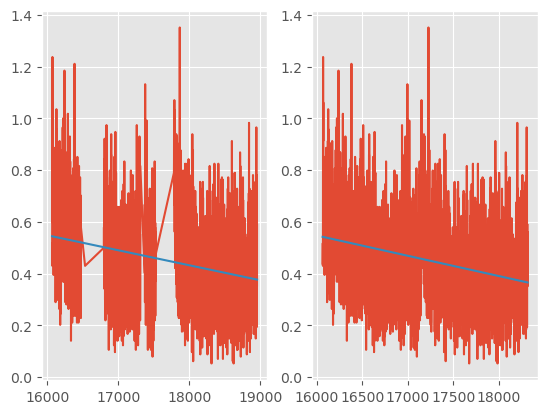

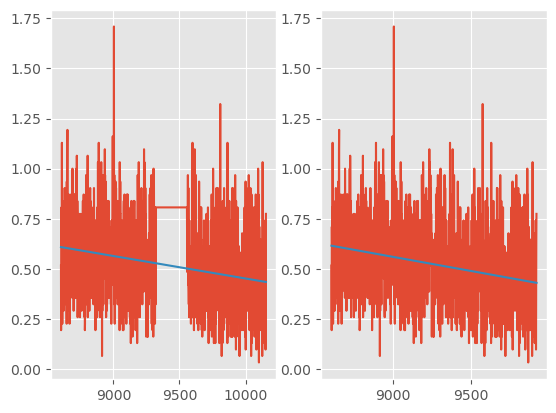

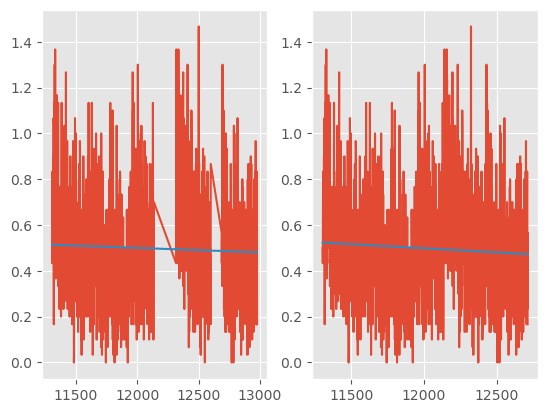

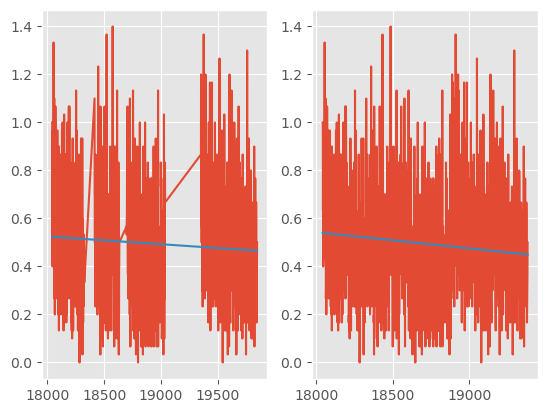

In [117]:
def main(base_folder,local_path,*args,**kwargs):
    stru = kwargs['stru']
    types = kwargs['types']
    time_from_border = kwargs['time_from_border']

    bk.load.current_session_linux(base_folder,local_path)
    states = bk.load.states(True)
    extended_sleep = bk.compute.extended(states)
    neurons, metadata = bk.load.spikes()
    neurons = neurons[(metadata.Region == stru) & (metadata.Type == types)]
    
    rvalues = {'sleep_time':[],
               'nrem_time':[]}
    bk.misc.discard_border(states['NREM'],20)
    for s, e in extended_sleep.iloc:
        current_sleep = nts.IntervalSet(s, e)

        state_intervals = states['NREM'].intersect(current_sleep)
        act = bk.compute.binSpikes(neurons,1,as_Tsd = True).restrict(state_intervals)
        t = act.times('s')
        act = np.mean(act.values,1)
        
        reg_sleep_time = scipy.stats.linregress(t,act)
        y_sleep_time = t*reg_sleep_time.slope + reg_sleep_time.intercept
        print(reg_sleep_time.rvalue**2)

        nrem_duration = state_intervals.tot_length('s')
        t_nrem_time = np.linspace(t[0],t[0]+nrem_duration,len(act))
        
        reg_nrem_time = scipy.stats.linregress(t_nrem_time,act)
        y_nrem_time = t_nrem_time*reg_nrem_time.slope + reg_nrem_time.intercept

        print(reg_nrem_time.rvalue**2)

        rvalues['sleep_time'].append(reg_sleep_time.rvalue**2)
        rvalues['nrem_time'].append(reg_nrem_time.rvalue**2)

        fig,ax = plt.subplots(1,2)
        ax[0].plot(t,act)
        ax[0].plot(t,y_sleep_time)

        ax[1].plot(t_nrem_time,act)
        ax[1].plot(t_nrem_time,y_nrem_time)
    return pd.DataFrame(rvalues)


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'time_from_border':20,
          'length_compute_fr':20}
main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
batch, metadata = bk.load.batch(main,**kwargs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sleep_time vs. nrem_time: t-test paired samples with Bonferroni correction, P_val:2.693e-02 t=-2.316e+00


(<AxesSubplot: xlabel='model', ylabel='r2'>,
 [<statannotations.Annotation.Annotation at 0x7f2ef708cb80>])

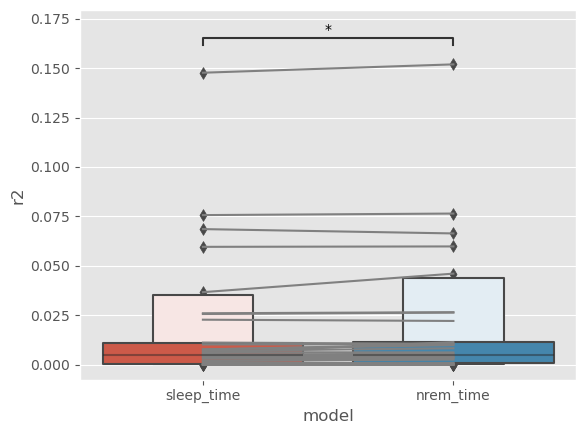

In [118]:
df = pd.concat(batch)
fig,ax = plt.subplots()

df_melt = df.melt(value_name='r2',var_name='model')
plotting_params = {'data':df_melt,
                   'x':'model',
                   'y':'r2',
                   'ax':ax}
values = np.array((df.sleep_time,df.nrem_time))
n_values = values.shape[1]
x = [[0]*n_values,[1]*n_values]
plt.plot(x,values,'grey')

sns.boxenplot(**plotting_params)
# plt.semilogy()
annotator = Annotator(pairs = [['sleep_time','nrem_time']],**plotting_params)
annotator.configure(test="t-test_paired",comparisons_correction = 'Bonferroni').apply_and_annotate()

In [121]:
df.mean()

sleep_time    0.016263
nrem_time     0.017088
dtype: float64

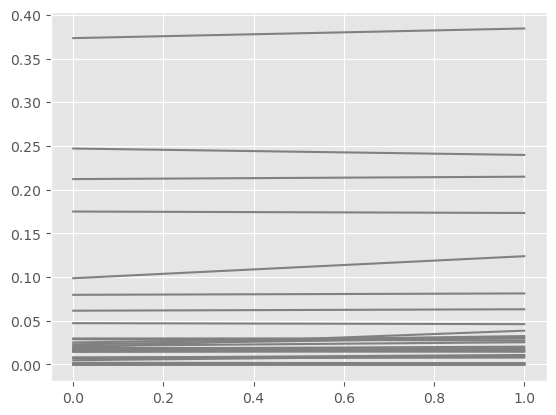

In [87]:
values = np.array((df.sleep_time,df.nrem_time))
n_values = values.shape[1]
x = [[0]*n_values,[1]*n_values]
plt.plot(x,values,'grey')

In [86]:
df

sleep_time  nrem_time
Rat08-20130708 0  7.641455e-03   0.010851
Rat08-20130709 0  1.441393e-02   0.015002
               1  1.802922e-02   0.016345
Rat08-20130712 0  1.010735e-03   0.001273
Rat08-20130713 0  2.124033e-02   0.025443
               1  1.642835e-04   0.000167
Rat09-20140324 0  4.725560e-02   0.046123
               1  3.348959e-04   0.000101
Rat09-20140325 0  2.888436e-02   0.027338
               1  5.954447e-04   0.000654
Rat09-20140326 0  1.980885e-03   0.001457
Rat09-20140327 0  6.151862e-02   0.063159
Rat09-20140331 0  3.733435e-01   0.384370
Rat09-20140401 0  1.801151e-02   0.020366
               1  6.106630e-07   0.001480
Rat09-20140402 0  2.519073e-02   0.032476
Rat10-20140619 0  4.261838e-05   0.000005
Rat10-20140620 0  3.515667e-04   0.000411
Rat10-20140624 0  2.542642e-04   0.000049
Rat10-20140626 0  2.304429e-02   0.030479
Rat10-20140627 0  1.630224e-02   0.014677
Rat10-20140629 0  7.968016e-02   0.081268
Rat10-20140701 0  1.896791e-02   0.018604
Rat10-20140702 0  1.517707e-02   0.017034
Rat10-20140703 0  2.974029e-02   0.029772
Rat10-20140704 0  7.409450e-03   0.007998
               1  3.050183e-05   0.000138
               2  8.038617e-03   0.008393
Rat11-20150323 0  1.749672e-01   0.173320
Rat11-20150326 0  9.868626e-02   0.123850
Rat11-20150327 0  2.120750e-01   0.214816
Rat11-20150330 0  2.470308e-01   0.239705
Rat11-20150331 0  4.890134e-03   0.010053
               1  1.943430e-02   0.038670

In [82]:
np.mean(d*100)

-0.23560637265292084

Ttest_1sampResult(statistic=-2.2878729708086487, pvalue=0.02868616955145936)

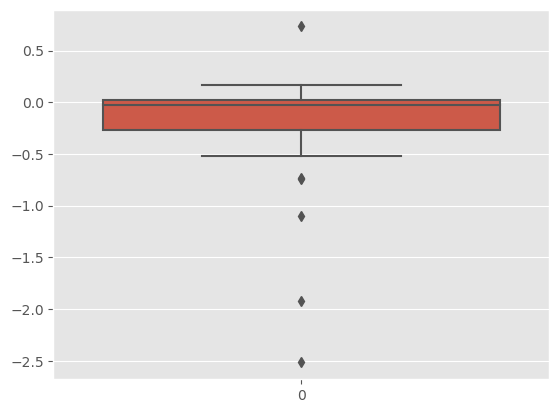

In [79]:
df = pd.concat(batch)
d = df['sleep_time']-df['nrem_time']
sns.boxplot(d*100)
scipy.stats.ttest_1samp(d,0)